# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
   
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    ```
   
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * [Albumentations](https://github.com/albumentations-team/albumentations) is another awesome solution.
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.  
    * But sometimes there is! Some examples of advanced image augmentation approaches: [mixup](https://arxiv.org/pdf/1710.09412.pdf), [cutmix](https://arxiv.org/pdf/1905.04899.pdf)   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms

# Uncomment this to disable "Skipping walk through <class 'list'>" warnings in DataSphere's env
# %enable_full_walk
data_path = '.'

Matplotlib is building the font cache; this may take a moment.


In [2]:
# downloading TinyImagenet
# you don't have to run this cell more than once

from tiny_img import download_tinyImg200, fix_test_data


# uncomment if there is no tiny-imagenet-200 in current dir

#download_tinyImg200(data_path)
#fix_test_data(data_path)

We will split `tiny-imagenet-200/train` dataset into train and val parts, and use  `tiny-imagenet-200/val` dataset as a test one.

You are free to use either the default ImageFolder Dataset, or the custom one, which will read and store the whole data in RAM. The second one is preferable only when you have a slow disk; make sure then you do have an extra couple of GiBs of memory (it also could take some time to load the images):

In [3]:
import os
imagenet_dir = os.path.join(data_path, 'tiny-imagenet-200')
dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
                                                           generator=torch.Generator().manual_seed(42))
test_dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/test', transform=transforms.ToTensor())

# OR

# from tiny_img_ram import TinyImagenetRAM
# dataset = TinyImagenetRAM('tiny-imagenet-200/train', transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
#                                                            generator=torch.Generator().manual_seed(42))
# test_dataset = TinyImagenetRAM('tiny-imagenet-200/val', transform=transforms.ToTensor())

### Initialize structures for saving results of training

In [4]:
import datetime
import tempfile
import random
import string
from os import path

# printing lowercase
letters = string.ascii_lowercase
print (  )

md_file_prefix = 'model_results_'

def get_temp_filename(name):
    result = None
    while result is None or path.exists(result):
        result =  name + '_' + ''.join(random.choice(letters) for i in range(5))
    return result

class ModelResults(object):
    def __init__(self, name):
        self.name = name
        self.timestamp = datetime.datetime.now()
        self.model_filename = get_temp_filename('models/' + name)
        self.comment = ''
        self.descr = ''
        self.params = {}
        self.stats = {}

### Describe model params

In [67]:
md = ModelResults('conv_net')
md.params = {
    'batch_size': 128,
    'lr': 0.00001,
    'optim': 'Adam'
}
md.comment = 'triple conv net with batchnorm and cached data augmentation '

In [68]:
print(md.params)

{'batch_size': 128, 'lr': 1e-05, 'optim': 'Adam'}


## Model and training definition

### Augment dataset

In [69]:
import torch.utils.data as data


class AugDataset(data.Dataset):

    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.cache = [None] * len(base_dataset)
        self.transform = torch.nn.Sequential(
            torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(10)
        )
    
    
    def __getitem__(self, idx):
        if self.cache[idx] is None:
            img, label = self.base_dataset[idx]
            self.cache[idx] = (self.transform(img), label)
        return self.cache[idx]
        
    def __len__(self):
        return len(self.base_dataset)


train_aug_only_dataset = AugDataset(train_dataset)

train_aug_dataset = torch.utils.data.ConcatDataset([train_aug_only_dataset,train_dataset])

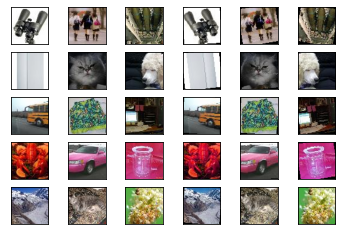

In [70]:
x_axis = 3
y_axis = 5
f, axarr = plt.subplots(y_axis, 2 * x_axis)
for y in range(y_axis):
    for x in range(x_axis):
        axarr[y,x].imshow(transforms.ToPILImage()(train_dataset[x_axis * y + x][0]))
        axarr[y, x].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axarr[y,x_axis + x].imshow(transforms.ToPILImage()(train_aug_only_dataset[x_axis * y + x][0]))
        axarr[y, x_axis + x].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [71]:
train_batch_gen = torch.utils.data.DataLoader(train_aug_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)
test_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=md.params['batch_size'],
                                              shuffle=True,
                                              num_workers=1)

In [72]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [73]:
torch.cuda.empty_cache()

Let's start with a dense network for our baseline:

In [75]:
#!L
model = nn.Sequential()

# reshape from "images" to flat vectors


model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding='same'))
model.add_module('batchnorm_conv1', nn.BatchNorm2d(128))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))

model.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'))
model.add_module('batchnorm_conv2', nn.BatchNorm2d(256))
model.add_module('conv2_relu', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))

model.add_module('conv3', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'))
model.add_module('batchnorm_conv3', nn.BatchNorm2d(512))
model.add_module('conv3_relu', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(2))


model.add_module('flatten', nn.Flatten())
# dense "head"
model.add_module('dense1', nn.Linear(512 * 64 * 64 // 64, 1024))
model.add_module('batchnorm_dense1', nn.BatchNorm1d(1024))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout2', nn.Dropout(0.30))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(1024, 200)) # logits for 200 classes



if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
model.to(device)
device

device(type='cuda', index=0)

In [76]:
#from torchinfo import summary

md.descr = str(model)
print(model)
#summary(model)
#summary(model, (128, 3, 3, 3))

Sequential(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm_conv1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm_conv2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_relu): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm_conv3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_relu): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=32768, out_features=1024, bias=True)
  (batchnorm

In [77]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [78]:
torch.cuda.reset_peak_memory_stats()

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [79]:
#!L
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device=device)
    y_batch = torch.LongTensor(y_batch).to(device=device)
    logits = model.to(device)(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

### Training on minibatches
* We got 100k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [80]:
import numpy as np

batch_size = md.params['batch_size']

opt = getattr(torch.optim, md.params['optim'])(model.parameters(), lr=md.params['lr'])

train_loss = []
val_accuracy = []

num_epochs = 50 # total amount of full passes over training data


best_epoch = 0
best_train_acc = -1
best_val_acc = -1


import time

start_counter = time.perf_counter()


for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)).to(device))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    train_acc = np.mean(train_loss[-len(train_dataset) // batch_size :])
    print("  training loss (in-iteration): \t{:.6f}".format(train_acc))
    val_acc = np.mean(val_accuracy[-len(val_dataset) // batch_size :])
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
    
    best_train_acc = train_acc
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), md.model_filename)
    if epoch > best_epoch + 5:
        break
    
stop_counter = time.perf_counter()
peak_ram = torch.cuda.max_memory_allocated()

Epoch 1 of 50 took 215.540s
  training loss (in-iteration): 	4.321626
  validation accuracy: 			17.52 %
Epoch 2 of 50 took 216.099s
  training loss (in-iteration): 	3.856120
  validation accuracy: 			22.38 %
Epoch 3 of 50 took 219.285s
  training loss (in-iteration): 	3.529441
  validation accuracy: 			25.29 %
Epoch 4 of 50 took 219.370s
  training loss (in-iteration): 	3.259037
  validation accuracy: 			27.21 %
Epoch 5 of 50 took 217.589s
  training loss (in-iteration): 	3.020405
  validation accuracy: 			28.69 %
Epoch 6 of 50 took 217.534s
  training loss (in-iteration): 	2.792145
  validation accuracy: 			29.52 %
Epoch 7 of 50 took 217.552s
  training loss (in-iteration): 	2.584081
  validation accuracy: 			30.21 %
Epoch 8 of 50 took 217.247s
  training loss (in-iteration): 	2.382575
  validation accuracy: 			30.75 %
Epoch 9 of 50 took 217.598s
  training loss (in-iteration): 	2.187971
  validation accuracy: 			31.09 %
Epoch 10 of 50 took 218.133s
  training loss (in-iteration): 	2.

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```

### Final test

In [52]:
print("Final results:")
print("  val accuracy:\t\t{:.2f} %".format(
    best_val_acc * 100))

if best_val_acc * 100 > 70:
    print("U'r freakin' amazin'!")
elif best_val_acc * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif best_val_acc * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif best_val_acc * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif best_val_acc * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  val accuracy:		26.92 %
Achievement unlocked: 60lvl Warlock!


When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [53]:
model.load_state_dict(torch.load(md.model_filename))
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)

In [54]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		26.97 %
Achievement unlocked: 60lvl Warlock!


## save model stats

In [58]:
md.stats = {
    'total_epoch': epoch + 1,
    'total_time': start_counter - stop_counter,
    'peak_ram': peak_ram,
    'best_epoch': best_epoch,
    'best_train_acc': best_train_acc,
    'best_val_acc': best_val_acc,
    'test_acc': test_accuracy
}

In [59]:
import pickle

name = get_temp_filename('models_stats/' + md.name)
with open(name, 'wb') as fout:
    pickle.dump(md, fout)
print('saved model stats in {}'.format(name))

saved model stats in models_stats/conv_net_erner


In [20]:
with open('models_stats/conv_net_guwtz', 'rb') as fin:
    new_md = pickle.load(fin)
print('{}:\n{}'.format(new_md.name, new_md.params))

conv_net:
{'batch_size': 50, 'lr': 1e-05, 'optim': 'AdamW'}


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]